In [ ]:
import pandas as pd
from datetime import datetime, timedelta


import numpy as np

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
!pip install requests
import requests

In [ ]:
# Replace 'your_api_token_here' with your actual Tiingo API token
api_token = '006fb064a2f4e8c83cb5c22a1fbe4179be29a75e'
ticker = 'TSLA'

# Calculate the start date (5 years ago from today)
end_date = datetime.now()-timedelta(days=30)
start_date =  datetime(1960, 1, 1)

# Format dates as strings
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# URL for historical prices
url = f'https://api.tiingo.com/tiingo/daily/{ticker}/prices?startDate={start_date_str}&endDate={end_date_str}'

headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Token {api_token}'
}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    data = response.json()
    print(f"Fetched {len(data)} days of data for tesla.")
else:
    print("Failed to fetch data. Status code:", response.status_code)


Fetched 3519 days of data for tesla.


In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import pandas as pd
# Convert JSON data to pandas DataFrame
df = pd.DataFrame(data)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3519 entries, 0 to 3518
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3519 non-null   object 
 1   close        3519 non-null   float64
 2   high         3519 non-null   float64
 3   low          3519 non-null   float64
 4   open         3519 non-null   float64
 5   volume       3519 non-null   int64  
 6   adjClose     3519 non-null   float64
 7   adjHigh      3519 non-null   float64
 8   adjLow       3519 non-null   float64
 9   adjOpen      3519 non-null   float64
 10  adjVolume    3519 non-null   int64  
 11  divCash      3519 non-null   float64
 12  splitFactor  3519 non-null   float64
dtypes: float64(10), int64(2), object(1)
memory usage: 357.5+ KB


In [ ]:
# Preprocess the data
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [ ]:
data = df['close'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1))


In [ ]:
# Function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

In [ ]:
seq_length = 60  # Sequence length of 60 days

# Create sequences
X, y = create_sequences(data, seq_length)


In [ ]:
split = len(X) - 30
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
# Reshape data for CNN-LSTM (samples, time steps, features)
X_train_cnn_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Define the CNN-LSTM model
cnn_lstm_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(seq_length, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu'),
    Dense(1)
])
cnn_lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the CNN-LSTM model
cnn_lstm_model.fit(X_train_cnn_lstm, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1)


Epoch 1/20
86/86 [==============================] - 9s 54ms/step - loss: 0.0043 - val_loss: 0.0015
Epoch 2/20
86/86 [==============================] - 5s 54ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 3/20
86/86 [==============================] - 5s 53ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 4/20
86/86 [==============================] - 4s 41ms/step - loss: 0.0011 - val_loss: 8.6844e-04
Epoch 5/20
86/86 [==============================] - 4s 41ms/step - loss: 9.2253e-04 - val_loss: 7.8154e-04
Epoch 6/20
86/86 [==============================] - 3s 38ms/step - loss: 8.9953e-04 - val_loss: 0.0011
Epoch 7/20
86/86 [==============================] - 5s 61ms/step - loss: 8.3411e-04 - val_loss: 0.0012
Epoch 8/20
86/86 [==============================] - 3s 38ms/step - loss: 8.1885e-04 - val_loss: 7.4334e-04
Epoch 9/20
86/86 [==============================] - 3s 33ms/step - loss: 7.0942e-04 - val_loss: 7.3548e-04
Epoch 10/20
86/86 [==============================] - 3s 32ms/step - loss:

In [ ]:
# Make predictions
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test_cnn_lstm)
y_pred_cnn_lstm = scaler.inverse_transform(y_pred_cnn_lstm)
y_test_cnn_lstm = scaler.inverse_transform(y_test.reshape(-1, 1))


1/1 [==============================] - 0s 233ms/step


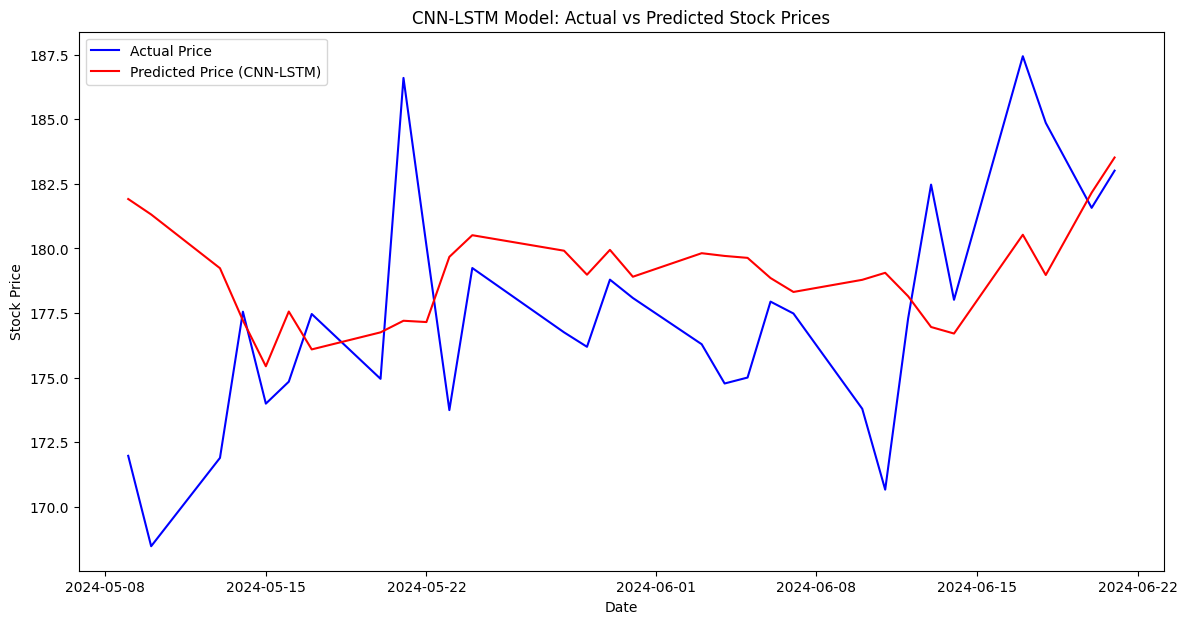

In [ ]:
# Plot CNN-LSTM results
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test_cnn_lstm):], y_test_cnn_lstm, color='blue', label='Actual Price')
plt.plot(df.index[-len(y_test_cnn_lstm):], y_pred_cnn_lstm, color='red', label='Predicted Price (CNN-LSTM)')
plt.title('CNN-LSTM Model: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
# Calculate metrics
mse_cnn_lstm = mean_squared_error(y_test_cnn_lstm, y_pred_cnn_lstm)
print(f'CNN-LSTM Model MSE: {mse_cnn_lstm}')

CNN-LSTM Model MSE: 25.242830563730834


**AUTO REGRESSOR MODEL (ARIMA)**

In [ ]:
# Fit ARIMA model
arima_model = ARIMA(data[:split], order=(5, 1, 0))
arima_model_fit = arima_model.fit()

In [ ]:
# Forecast the next 30 days
y_pred_arima = arima_model_fit.forecast(steps=30)
y_pred_arima = scaler.inverse_transform(y_pred_arima.reshape(-1, 1))


In [ ]:
# Inverse transform the actual test data
y_test_arima = scaler.inverse_transform(y_test.reshape(-1, 1))

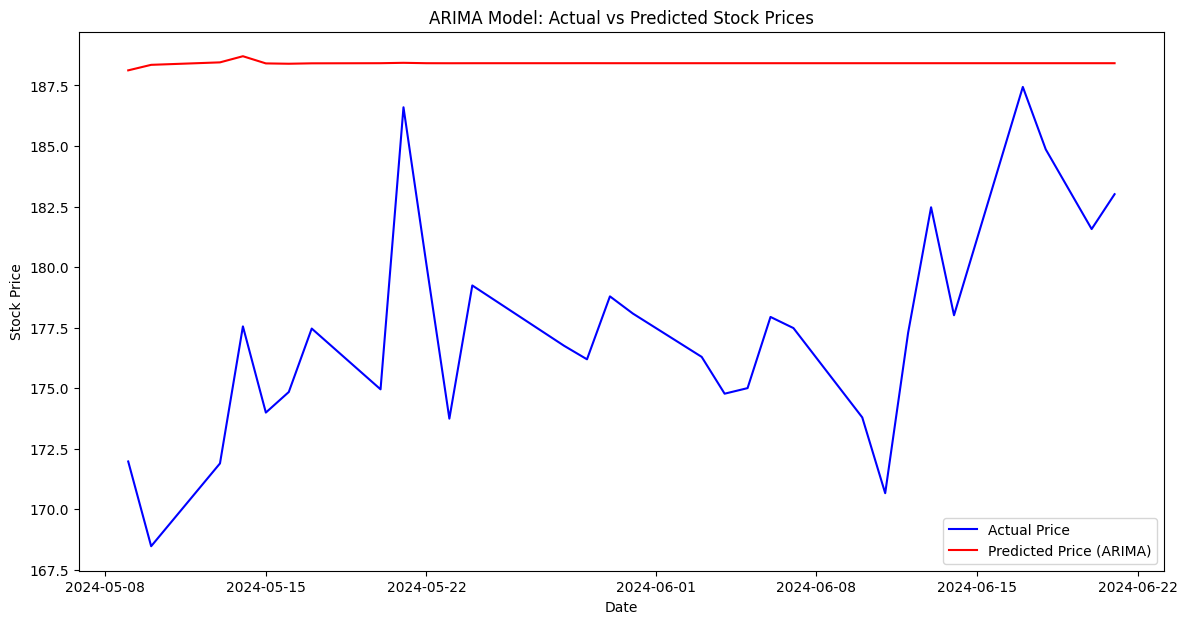

ARIMA Model MSE: 141.2007429859356


In [ ]:
# Plot ARIMA results
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test_arima):], y_test_arima, color='blue', label='Actual Price')
plt.plot(df.index[-len(y_test_arima):], y_pred_arima, color='red', label='Predicted Price (ARIMA)')
plt.title('ARIMA Model: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Calculate metrics
mse_arima = mean_squared_error(y_test_arima, y_pred_arima)
print(f'ARIMA Model MSE: {mse_arima}')

**Transformer model**

In [ ]:
pip install ydata-synthetic


In [ ]:
# Add positional encoding
def add_positional_encoding(X):
    position = np.arange(X.shape[1])[:, np.newaxis]
    div_term = np.exp(np.arange(0, X.shape[2], 2) * -(np.log(10000.0) / X.shape[2]))
    pos_enc = np.zeros(X.shape)
    pos_enc[:, :, 0::2] = np.sin(position * div_term)
    pos_enc[:, :, 1::2] = np.cos(position * div_term)
    return X + pos_enc

In [ ]:
# Add positional encoding
X_train_transformer = add_positional_encoding(X_train_cnn_lstm)
X_test_transformer = add_positional_encoding(X_test_cnn_lstm)

In [ ]:
from tensorflow.keras.layers import Input, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model


In [ ]:
# Define Transformer model
def transformer_model(seq_length, d_model, num_heads, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
    inputs = Input(shape=(seq_length, 1))
    x = Dense(d_model)(inputs)

    for _ in range(num_encoder_layers):
        x = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = Dropout(dropout)(x)
        x = LayerNormalization(epsilon=1e-6)(x)

    for _ in range(num_decoder_layers):
        x = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = Dropout(dropout)(x)
        x = LayerNormalization(epsilon=1e-6)(x)

    outputs = Dense(1)(x)
    return Model(inputs, outputs)

In [ ]:
# Set hyperparameters
num_heads = 8
d_model = 512
num_encoder_layers = 2
num_decoder_layers = 2
dim_feedforward = 2048
dropout = 0.1
epochs = 1
batch_size = 32

In [ ]:
# Instantiate and compile the Transformer model
transformer = transformer_model(seq_length, d_model, num_heads, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
transformer.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the Transformer model
transformer.fit(X_train_transformer, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

86/86 [==============================] - 971s 11s/step - loss: 18.2569 - val_loss: 0.0361


In [ ]:
y_pred_transformer = transformer.predict(X_test_transformer)


1/1 [==============================] - 5s 5s/step


In [ ]:
# Reshape the predictions to a 2D array
y_pred_transformer = y_pred_transformer.reshape(-1, 1)
y_test_transformer = y_test.reshape(-1, 1)

In [ ]:
# Apply inverse transform to get the original scale
y_pred_transformer = scaler.inverse_transform(y_pred_transformer)
y_test_transformer = scaler.inverse_transform(y_test_transformer)

In [ ]:
y_pred_transformer = y_pred_transformer[-30:]
y_test_transformer = y_test_transformer[-30:]

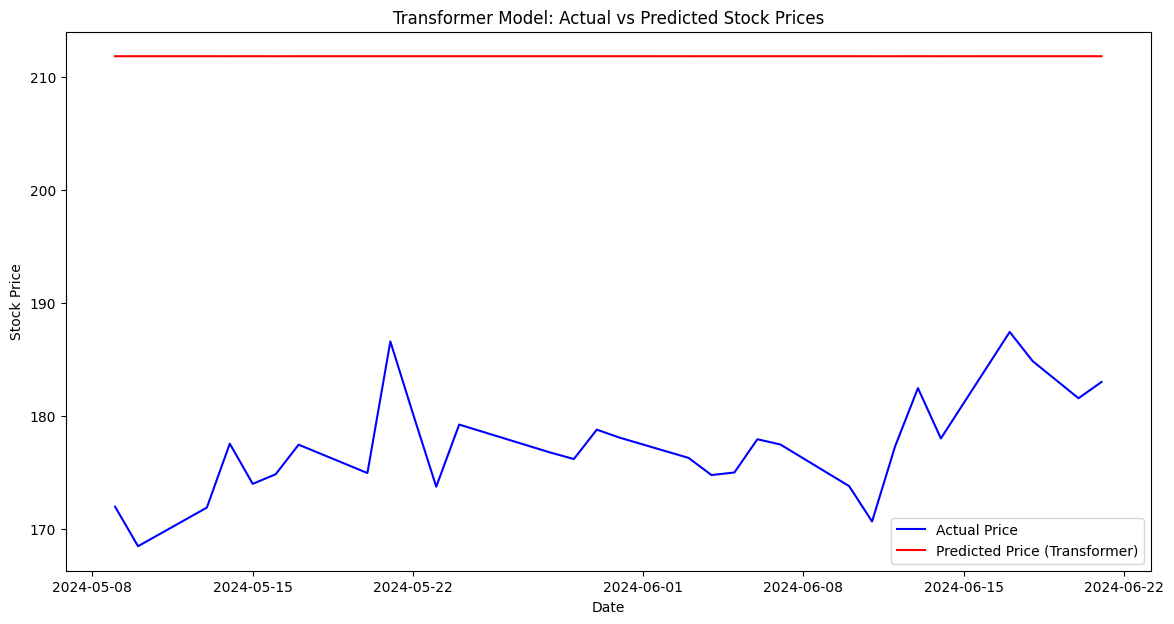

Transformer Model MSE: 1208.0743044622154


In [ ]:
# Plot Transformer results
plt.figure(figsize=(14, 7))
plt.plot(df.index[-30:], y_test_transformer, color='blue', label='Actual Price')
plt.plot(df.index[-30:], y_pred_transformer, color='red', label='Predicted Price (Transformer)')
plt.title('Transformer Model: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Calculate metrics
mse_transformer = mean_squared_error(y_test_transformer, y_pred_transformer)
print(f'Transformer Model MSE: {mse_transformer}')